In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# Introduction

This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know. 

We develop our models using TensorFlow and TensorFlow Probability (TFP). TFP is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability (TFP) and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).

As usual, the code is available on my GitHub.

# Distribution Objects

## Univariate Distributions

Distribution objects capture the essential operations on probability distributions. Let's start with the simplest form - univariate distributions. As the name indicates, these are distributions with only one random variable. A Gaussian distribution is a continuous probability distribution fully defined by its mean and standard deviation. Its standard form is a special case where μ = 0 and σ = 1.

$$\begin{align}
\mathcal{N} &= (\mu,\sigma) \\
\mu &= 0 \\
\sigma &= 1 \\
\end{align}$$

In [7]:
normal = tfd.Normal(loc=0, scale=1)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

Notice the properties batch_shape and event_shape. The event_shape  the property captures the dimensionality of the random variable. Since we defined a univariate distribution the event_shape is empty. The batch_shaperepresents the number of different independent distribution objects that we are storing in our object. In this case, we are storing only one distribution hence it is empty.

What can we do with this distribution object? We can, for instance, sample from it.

In [8]:
# Draw one sample from the normal distribution

normal.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=1.1830041>

In [9]:
# Draw 3 samples from the normal distribution

normal.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.4774938, -0.0801561,  1.1142303], dtype=float32)>

We can also evaluate the Probability Density Function (PDF), in the case of continuous random variables, on a given input.

In [10]:
normal.prob(0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3910427>

When we start  implementing Machine Learning and Deep Learning algorithms we will often find ourselves facing a common problem: multiplying probabilities is not fun. The overall product starts to approach zero quickly and you will run out of precision to store such tiny numbers.
A common workaround for this situation is to represent probabilities as log probabilities instead. This transformation works for a number of reasons:
* Since the probability of an event happening is always between 0 and 1, the log probability is always between −∞ and 0 (a much wider range of numbers than between 0 and 1);
* If a < b, then ln a < ln b. This property of logarithms means that comparing probabilities to figure out which one is the biggest is equivalent to comparing the log probabilities;
* Finally, the math works out nicely because the logarithm of a product is the sum of the logarithms (that is, ln(a · b) = ln a + ln b).

In TFP working with log probabilities is trivial, we just need to call a different method.

In [11]:
normal.log_prob(0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9389385>

Notice that the above is simply the natural logarithm of the value returned by theprobmethod.

In [12]:
np.log(normal.prob(0.2))

-0.9389385

Finally, we can plot a histogram, which approximates the density of the distribution.

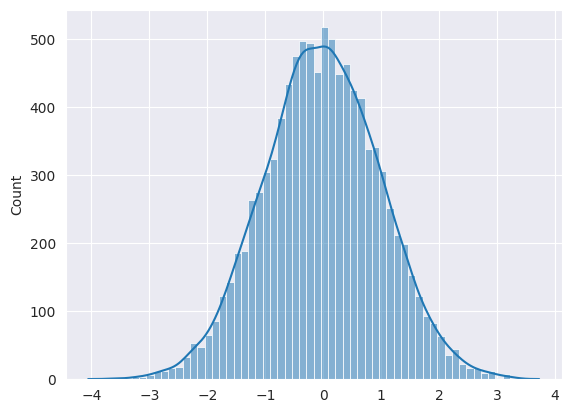

In [14]:
sns.histplot(data=normal.sample(10000).numpy(), kde=True);

Now, let's explore how we can in a single object store a batch of distributions. Let's create two univariate normal distributions, one with μ=0 and σ=1 and another with μ=1 and σ=1.

In [28]:
normal_batch = tfd.Normal([0,1],[1,2])
normal_batch

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

Note that these two distributions need to be of the same type (in this case they are both Gaussian) and they are considered independent, i.e. this is not the way to create multivariate distributions. In the above output, you can see that the batch_shapeis now 2 as expected.

We can sample from both distributions easily.

In [29]:
normal_batch.sample(3)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.5531085 ,  1.4462973 ],
       [-0.5346463 ,  0.63747466],
       [-2.2433918 , -0.4113649 ]], dtype=float32)>

''

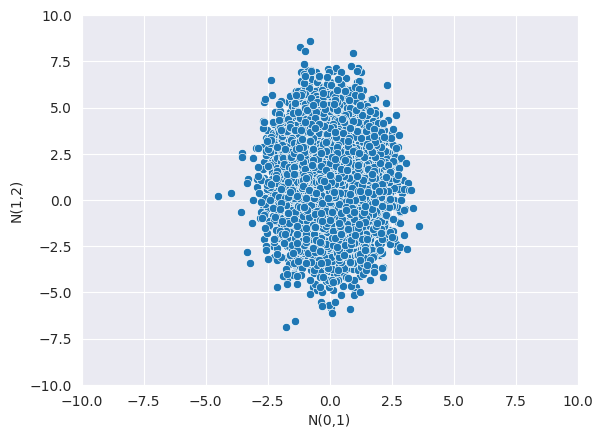

In [70]:
samples = normal_batch.sample(10000).numpy()
ax = sns.scatterplot(x = samples[:,0], y = samples[:,1])
ax.set(ylim=(-10, 10), xlim=(-10, 10), xlabel='N(0,1)', ylabel='N(1,2)');

In the same way, we can get the values for the PDFs of both distributions.

In [54]:
normal_batch.prob([1,2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.24197073, 0.17603266], dtype=float32)>

We get a returned tensor of shape (2,) since we are getting the PDF values for both distributions in the two different points that we supplied.

As an exercise to understand better how the shapes behave, let's increase the rank of our batch_shape.

In [33]:
# Use a batch shape with higher rank

normal_batch_D = tfd.Normal([[[0., 2],
                             [0.5, 1],
                             [5, 2]]], scale=1)
normal_batch_D

<tfp.distributions.Normal 'Normal' batch_shape=[1, 3, 2] event_shape=[] dtype=float32>

We now have 6 different Gaussian distributions stored in the same object. Can you tell what is the mean and standard deviation of normal_batch_D[0,2,1] without running the code?

As usual, we can sample from it.

In [34]:
# Sample from the batch of distributions

normal_batch_D.sample(10)

<tf.Tensor: shape=(10, 1, 3, 2), dtype=float32, numpy=
array([[[[-0.94896364,  2.1813042 ],
         [ 0.14763275,  0.22235268],
         [ 4.8377185 , -0.19643283]]],


       [[[ 0.6483533 ,  2.3491006 ],
         [-0.11504221,  0.13614637],
         [ 5.2141023 ,  1.9243499 ]]],


       [[[ 0.14039962,  1.5450974 ],
         [ 1.134828  ,  2.2807612 ],
         [ 5.892858  ,  0.6847892 ]]],


       [[[ 1.3779826 ,  2.0819554 ],
         [ 1.0930698 ,  0.5755873 ],
         [ 4.71762   ,  2.248595  ]]],


       [[[ 0.21968068,  1.2137487 ],
         [ 1.3834007 , -0.17327452],
         [ 5.6132197 ,  2.4669297 ]]],


       [[[-0.7178315 ,  1.1999301 ],
         [-0.19561946,  0.14512819],
         [ 3.7195773 ,  1.3497605 ]]],


       [[[ 0.03890136,  2.9174664 ],
         [ 0.37707615, -1.6925879 ],
         [ 4.0377812 ,  2.6682882 ]]],


       [[[ 1.4869312 ,  2.2919848 ],
         [ 1.1833754 ,  0.78834504],
         [ 4.746928  ,  2.398845  ]]],


       [[[-2.2711177 ,  1

We get a tensor with shape (10, 1, 3, 2), which just means that we have 10 samples (the first dimension) for each of the 6 Gaussian distributions.

## Multivariate Distributions

Now, it is time to explore theevent_shapeproperty of our distribution objects. There are multiple ways to create a multivariate distribution, let's start with the simplest one. We can define a 2-dimensional Gaussian distribution and not include any correlation between the two dimensions, which means that the off-diagonal terms of the covariance matrix are 0.

$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 1] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix}
\end{align}$$

In [49]:
mv_normal = tfd.MultivariateNormalDiag(loc=[0, 1], scale_diag=[1., 2])
mv_normal

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

Finally, we see anevent_shapepopulated, in this case with a value of 2. As we stated this is the dimensionality of our random variable defined above.

Time to sample from it and see the differences compared to multiple batched distributions.

In [50]:
# Sample from the multivariate normal

mv_normal.sample(3)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.4743712 , -0.77387524],
       [ 1.7382311 ,  2.747313  ],
       [-1.3609515 ,  4.8874683 ]], dtype=float32)>

The shape is exactly the same as in the example where we sampled 3 times from two batched distributions. In fact, since we have defined a multivariate distribution with an off-diagonal covariance matrix (the dimensions are independent) we are getting similar results - compare figure 3 with figure 2.

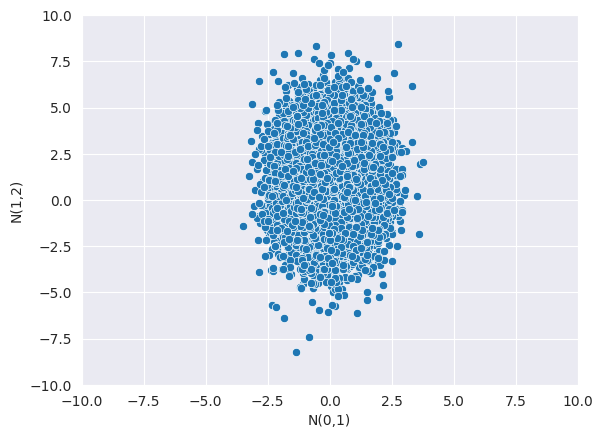

In [71]:
# Plot the samples of the distribution

samples = mv_normal.sample(10000).numpy()
ax = sns.scatterplot(x = samples[:,0], y = samples[:,1])
ax.set(ylim=(-10, 10), xlim=(-10, 10), xlabel='N(0,1)', ylabel='N(1,2)');

Time to start bringing both concepts together and defining a batch of multivariate distributions.

The data is more spread out in the second dimension (y-axis) as we defined a scale that is twice the value used for the first dimension. Also, there is no correlation between the dimensions, as we used a diagonal multivariate normal distribution (off-diagonal terms are 0).

We can define a batch of multivariate distributions.

$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 0] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix} \\[10pt]
\mathcal{N_2} &= (\mu_2,\Sigma_2) \\
\mu_2 &= [1, 1] \\
\Sigma_2 &= \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix} \\[10pt]
\mathcal{N_3} &= (\mu_3,\Sigma_3) \\
\mu_3 &= [0, 0] \\
\Sigma_3 &= \begin{bmatrix}
2 & 0\\
0 & 10
\end{bmatrix}
\end{align}$$

In [15]:
normal_diag_batch = tfd.MultivariateNormalDiag(loc=[[0,0], [1,1], [0,0]],
                                              scale_diag=[[1,2], [1,1], [2,10]])
normal_diag_batch

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

We can see now that both batch_shape and event_shapeare populated, with values 3 and 2 respectively. It means that we have created 3 2-dimensional Gaussian distributions.

In [75]:
samples = normal_diag_batch.sample(10000).numpy()
samples.shape

(10000, 3, 2)

When sampling we get an output with the following dimensions: (number_samples, batch_shape, event_shape).
Let's explore computing the log probability of this object. What is the shape of the output that you are expecting to see?

In [76]:
normal_diag_batch.log_prob(samples)

<tf.Tensor: shape=(10000, 3), dtype=float32, numpy=
array([[-2.5595174, -1.8528149, -5.7963095],
       [-3.219818 , -2.9775417, -9.757326 ],
       [-5.3475537, -1.8487425, -6.300317 ],
       ...,
       [-3.3621025, -3.5017567, -6.5536766],
       [-2.7969153, -2.8572762, -5.0501986],
       [-3.2498784, -2.2819252, -7.9784765]], dtype=float32)>

Since we have 3 distributions (despite the fact that they are 2-dimensional), we get an output of (number_samples, batch_shape).

We can plot samples from the 3 distributions to compare how impactful is to have different diagonal values in the covariance matrix.

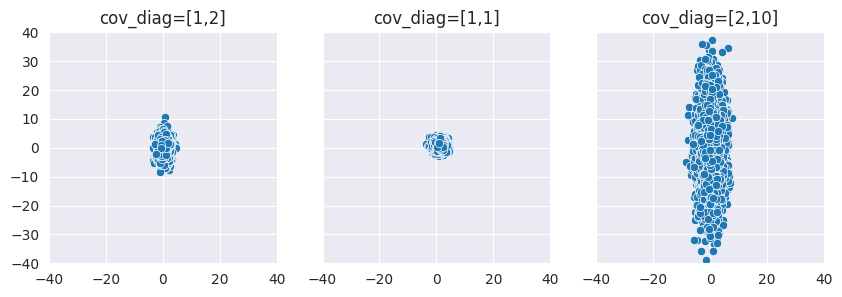

In [85]:
# Plot the samples of the mv normal

plt_sample_batch = normal_diag_batch.sample(10000).numpy()

fig, axs = (plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3)))
titles = ['cov_diag=[1,2]', 'cov_diag=[1,1]', f'cov_diag=[2,10]']

for i, (ax, title) in enumerate(zip(axs, titles)):
    samples = plt_sample_batch[:,i,:]
    sns.scatterplot(x=samples[:,0], y=samples[:,1], ax=ax)
    ax.set_title(title)
    axs[i].set_ylim(-40, 40)
    axs[i].set_xlim(-40, 40)
plt.show()

Notice that no correlation arises in this plot for any of the distributions. Even so, the third distribution is extremely elongated in the y-axis direction. This is due to the fact that the second value in the  diagonal is large compared to the first one - the standard deviation of the second dimension is much larger than the first, hence the spread we see in the y direction.

# Conclusion

This article covered the first steps to understanding the core objects in TFP - distribution objects. We start by defining univariate distributions and manipulating the batch_shapeproperty of the object as well as testing out different methods: sample, proband log_prob. Next, we moved to increase the dimensionality of our random variables and introduced multivariate distributions. In this case, we explored ways to work with thebatch_shapeandevent_shapeproperties of a single object, allowing us to store multiple multivariate distributions in a single object.

Next week, we will explore how can we actually train the parameters of these distribution objects. See you then!

# References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)